In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

In [0]:
transform = transforms.Compose([transforms.Resize((28,28)), #make any image 28x28 
                               transforms.ToTensor(),       #make a tensor
                               transforms.Normalize((0.5,), (0.5,))
                               ])
training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)


There's been an update to the code which applies to the MNIST section of this course. When normalizing the images, make sure to write transforms.Normalize((0.5,), (0.5,))  , rather than what we had earlier, transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) . Ultimately, this is done to ensure a single channel of (1, 28, 28), rather than (3, 28, 28).

In [0]:
def im_convert(tensor):
  image = tensor.clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  #print(image.shape)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image


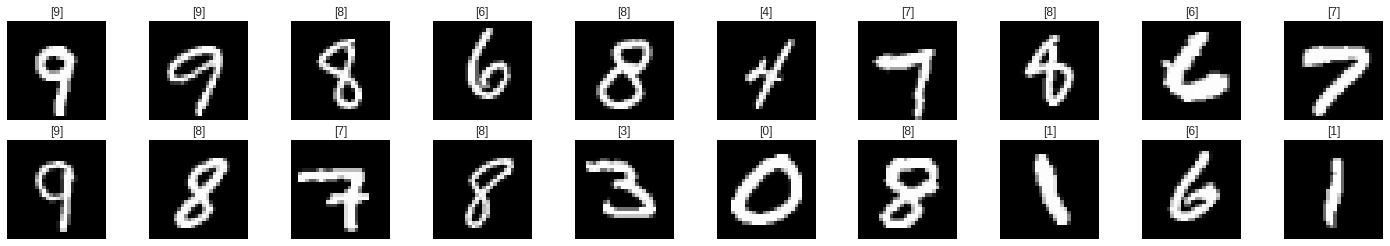

In [0]:


dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title([labels[idx].item()])



Neural Network


In [0]:
class Classifier(nn.Module):
    
    def __init__(self, D_in, H1, H2, D_out):
        super().__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, D_out)
    def forward(self, x):
        x = F.relu(self.linear1(x))  
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x



In [0]:
model = Classifier(784, 125, 65, 10 )    # number of pixels nodes in first layer , second layer, classes to put 
model

Classifier(
  (linear1): Linear(in_features=784, out_features=125, bias=True)
  (linear2): Linear(in_features=125, out_features=65, bias=True)
  (linear3): Linear(in_features=65, out_features=10, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [0]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.view(inputs.shape[0],-1) # 1,28,28   ---> 1, 784                                      
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  else:
    with torch.no_grad(): #this is to save memory by settng all grads flags to false for this segment 
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.view(val_inputs.shape[0], -1)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/ len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 0.9505, acc 76.4900 
validation loss: 0.4163, validation acc 88.8700 
epoch : 2
training loss: 0.3718, acc 89.5667 
validation loss: 0.3220, validation acc 90.7800 
epoch : 3
training loss: 0.3150, acc 90.8250 
validation loss: 0.2870, validation acc 91.7900 
epoch : 4
training loss: 0.2853, acc 91.7483 
validation loss: 0.2657, validation acc 92.2800 
epoch : 5
training loss: 0.2635, acc 92.3517 
validation loss: 0.2485, validation acc 92.8600 
epoch : 6
training loss: 0.2446, acc 92.8750 
validation loss: 0.2315, validation acc 93.0800 
epoch : 7
training loss: 0.2283, acc 93.3400 
validation loss: 0.2170, validation acc 93.5600 
epoch : 8
training loss: 0.2138, acc 93.8283 
validation loss: 0.2068, validation acc 93.9400 
epoch : 9
training loss: 0.1997, acc 94.2150 
validation loss: 0.1936, validation acc 94.2900 
epoch : 10
training loss: 0.1868, acc 94.6017 
validation loss: 0.1851, validation acc 94.5100 
epoch : 11
training loss: 0.1750, acc 94.8667 
va

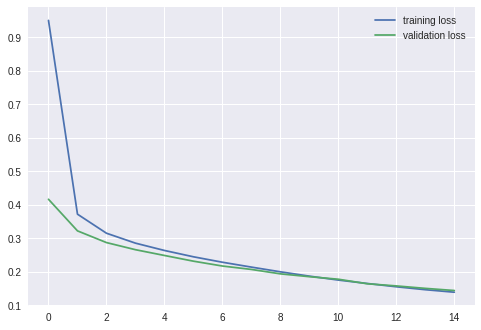

In [0]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

looks like it is right around 13 where it shows about right validation error starts to go further and separate from the training and is the balance where it needs to fit. 

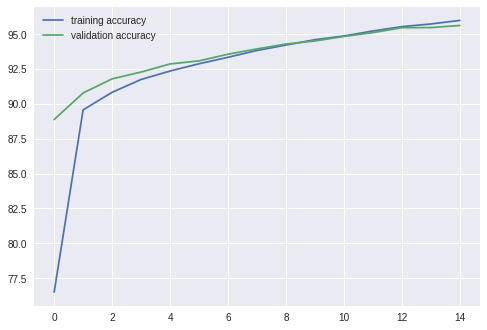

In [0]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

the training loss and validation loss begin to approach eachother the training loss begins to be less then the validation loss and that is where it begins to over fit. 

In [0]:
!pip3 install pillow==4.0.0

In [0]:
import PIL.ImageOps

<Response [200]>


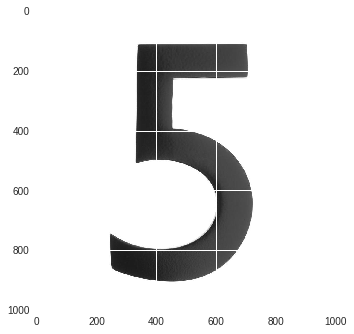

In [0]:
import requests
from PIL import Image

url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
response = requests.get(url, stream = True)
print(response)  #Response [200] successful

img = Image.open(response.raw)
plt.imshow(img)


preprocess from 1000x1000 to 28x28
and black number w/ white background to white number with black background

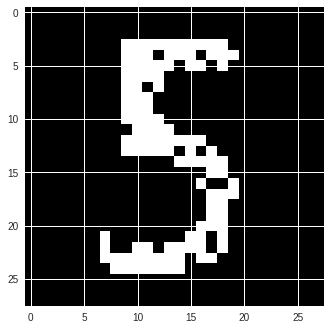

In [0]:
img = PIL.ImageOps.invert(img)  # invert colours
img = img.convert('1') # from RGB to black&white
img = transform(img) # transform image from 2nd cell

              
plt.imshow(im_convert(img))

In [0]:
img = img.view(img.shape[0], -1)
output = model(img)
_, pred = torch.max(output, 1)


print (pred.item())

5


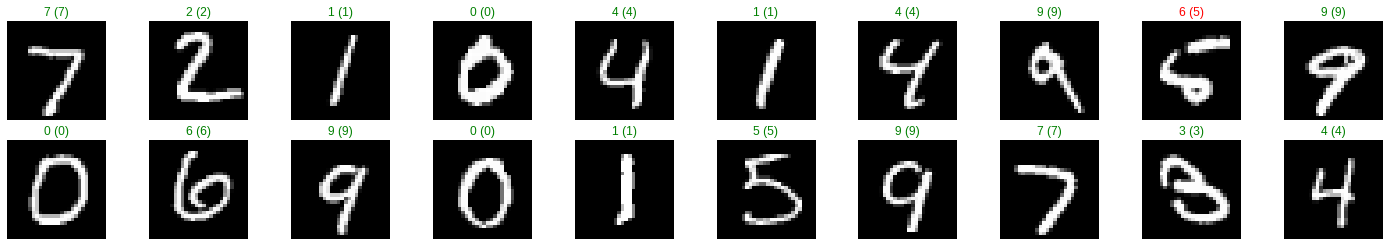

In [0]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images_ = images.view(images.shape[0], -1)
output = model(images_)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(preds[idx].item()), 
                                str(labels[idx].item())), 
               color=("green" if preds[idx]==labels[idx] else "red"))
